# WHO: Life Expectancy Dataset
**Project Goals**:
 - Wrangle WHO dataset to increase usability for project.
 - Utilize dataset to explore correlating features to life expectancy.
 - Create machine learning model to predict life expectancy.

In [35]:
import pandas as pd
import numpy as np
import wrangle
import explore

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

## Acquire Data

In [2]:
df = wrangle.acquire_who_data()

In [3]:
df.sample(5).T

,773,1830,920,2389,462
Country,Dominican Republic,Netherlands,Finland,Somalia,Cabo Verde
Year,2012,2014,2009,2003,2001
Status,Developing,Developed,Developing,Developing,Developing
Life expectancy,72.1,81.7,79.7,51.1,73
Adult Mortality,174,58,91,344,152
infant deaths,6,1,0,48,0
Alcohol,5.93,0.01,9.96,0.01,3.81
percentage expenditure,857.131,1491.7,579.738,0,150.743
Hepatitis B,74,92,NaN,NaN,NaN
Measles,0,140,2,8257,0


In [4]:
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1647,Malta,2002,Developed,78.2,75.0,0,5.73,1552.740429,NaN,7,...,95.0,7.86,95.0,0.1,11843.93920,395969.0,0.7,0.7,0.786,13.8
645,Croatia,2011,Developed,77.0,14.0,0,12.19,1913.356642,97.0,12,...,96.0,7.80,96.0,0.1,14539.18421,428622.0,1.6,1.5,0.808,14.5
67,Antigua and Barbuda,2012,Developing,75.9,134.0,0,8.18,2156.229842,98.0,0,...,97.0,5.39,98.0,0.2,12565.44197,NaN,3.3,3.3,0.778,13.8


### Acquire Takeaways:
 - I brought in my data using my acquire function
 - My info function gives me insight into the data types and null counts in my df
 - I will need to strip whitespaces from column names, lowercase and rename as well.
 - I will definitely need to impute some nulls because dropping would be too much
 - A distplot will give me a good idea of how to impute our nulls

## Prepare Data

In [5]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [6]:
df = wrangle.prep_who(df)

In [7]:
df.head()

,country,year,developed_country,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hep_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19yrs,thinness_5-9yrs,income_comp_resources,yrs_education
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


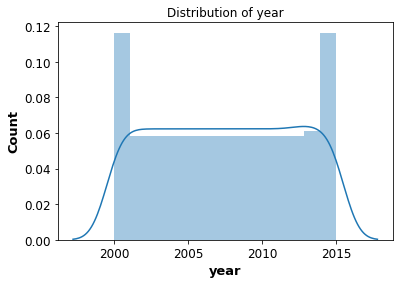

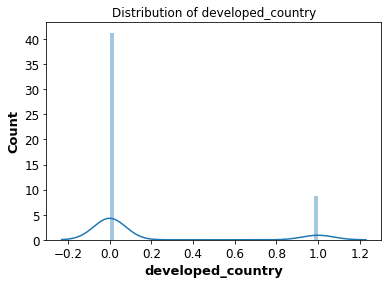

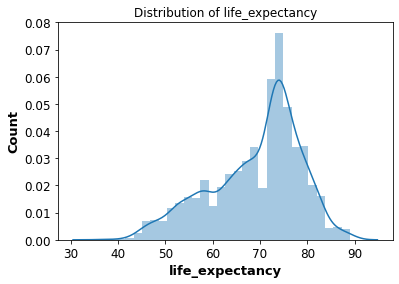

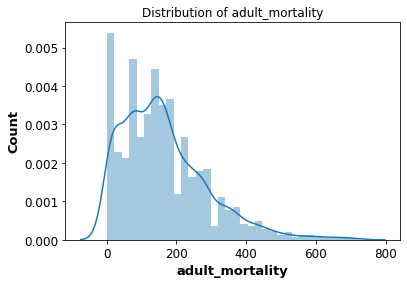

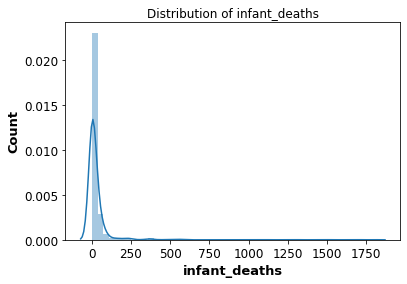

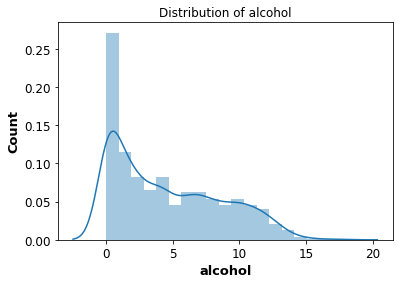

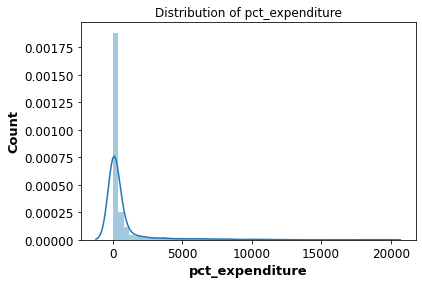

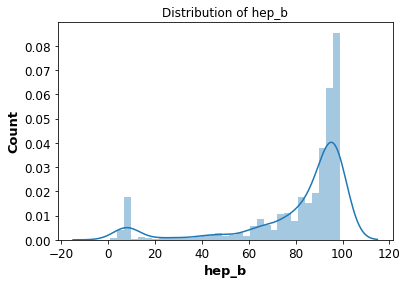

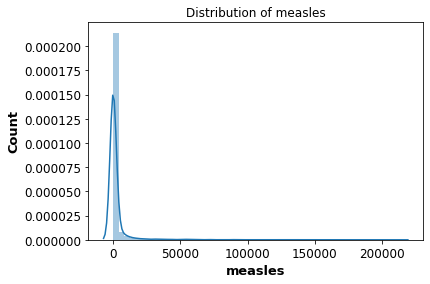

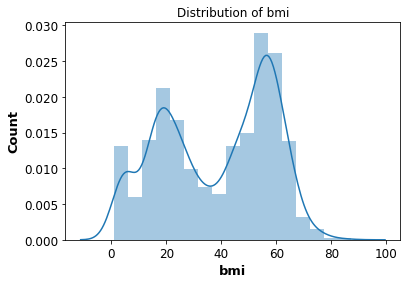

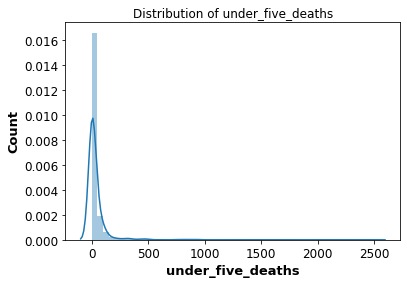

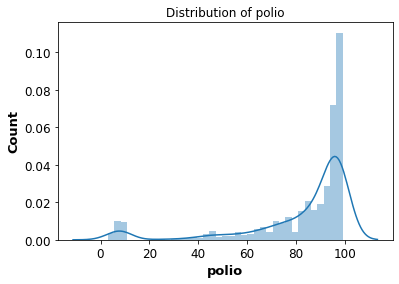

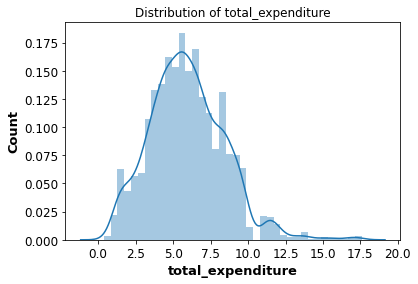

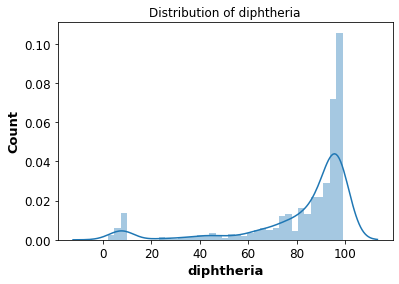

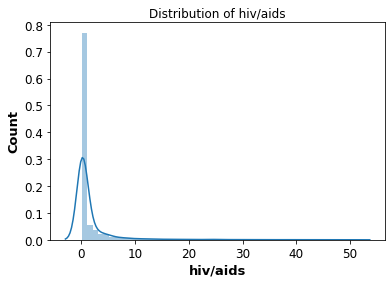

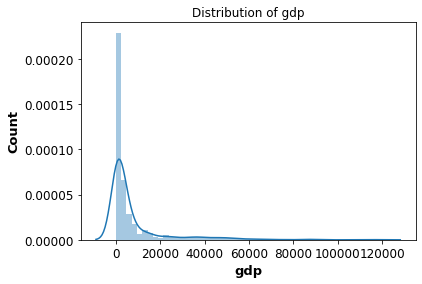

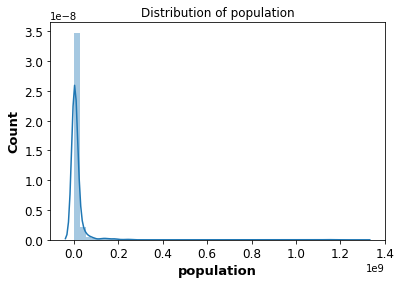

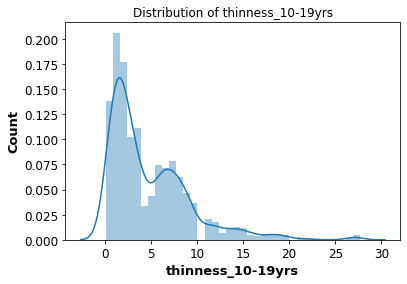

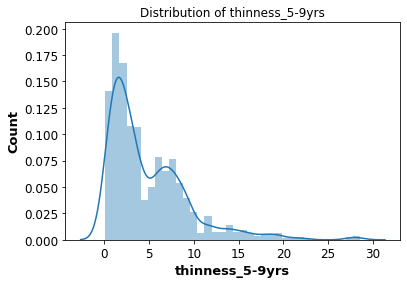

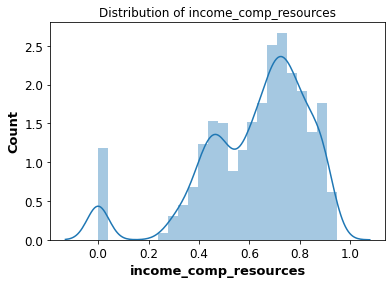

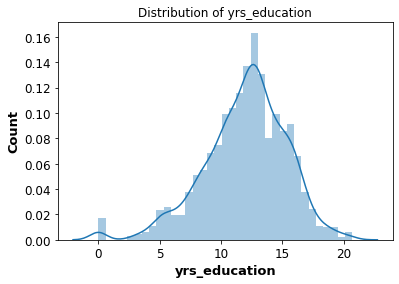

In [8]:
# take a look at distributions of numerical columns using my distplot function 
# get a better handle on the distribution to impute null entries
explore.distplot(df, df.columns)

In [9]:
df.sample(10).T

,1905,2330,871,1898,233,2704,1275,607,815,2110
country,Nigeria,Slovakia,Estonia,Nigeria,Belarus,Turkmenistan,Israel,Comoros,Egypt,Republic of Moldova
year,2003,2014,2010,2010,2006,2008,2006,2000,2002,2008
developed_country,0,1,0,0,0,0,0,0,0,0
life_expectancy,48.1,76.4,75.6,52,68.9,64.5,84,59.5,68.7,68.9
adult_mortality,41,113,137,374,243,235,68,272,177,228
infant_deaths,567,0,0,521,1,6,1,1,61,1
alcohol,9.75,10.6,14.97,8.9,12.6,2.4,2.23,0.09,0.15,9.07
pct_expenditure,30.1955,0,1802.02,133.123,364.426,34.2398,33.5862,35.0295,0,0
hep_b,NaN,97,94,49,98,96,96,NaN,97,97
measles,141258,0,0,8491,149,0,9,0,653,0


In [10]:
# investigate the nulls
df.isnull().sum()

country                    0
year                       0
developed_country          0
life_expectancy           10
adult_mortality           10
infant_deaths              0
alcohol                  194
pct_expenditure            0
hep_b                    553
measles                    0
bmi                       34
under_five_deaths          0
polio                     19
total_expenditure        226
diphtheria                19
hiv/aids                   0
gdp                      448
population               652
thinness_10-19yrs         34
thinness_5-9yrs           34
income_comp_resources    167
yrs_education            163
dtype: int64

In [11]:
# handle the nulls using the function I created for the dataframe
df = wrangle.handle_who_nulls(df)

In [12]:
# double check nulls are handled
df.isnull().sum()

country              0
year                 0
developed_country    0
life_expectancy      0
adult_mortality      0
infant_deaths        0
alcohol              0
pct_expenditure      0
hep_b                0
measles              0
bmi                  0
under_five_deaths    0
polio                0
total_expenditure    0
diphtheria           0
hiv/aids             0
thinness_10-19yrs    0
thinness_5-9yrs      0
yrs_education        0
dtype: int64

In [13]:
# check how much of the data we're left with
df.shape

(2709, 19)

In [14]:
# split data for exploration and scaling
train, validate, test = wrangle.split_data(df)

train---> (1516, 19)
validate---> (651, 19)
test---> (542, 19)


In [15]:
# use robust scaler on my dataframe, using robust because some of the data is skewed and 
# has some outliers that cannot be addressed

# assign the columns I want to scale
numeric_cols = ['year', 'adult_mortality', 'infant_deaths', 'pct_expenditure',
               'measles', 'under_five_deaths', 'yrs_education']

# use my robust scaler function to scaled my X dataframes
train_scaled, validate_scaled, test_scaled, scaler = wrangle.robust_scaler(train, validate, test, numeric_cols)

### Prepare Takeaways:
 - Used my prep function to rename columns and hot encode developed countries into discrete variable
 - Visualized distribution to assess how to fill my null values and which were necessary to drop
 - Created a handle nulls function to impute null values with mean average and backfill values grouped by country
 - Split my data for exploration and modeling
 - Used robust scaler to scale my numeric columns

## Explore

In [16]:
# visualize distribution of ytarget
train_scaled.sample(5).T

,1447,604,2854,817,2520
country,Latvia,Comoros,Vanuatu,Egypt,Sweden
year,0.375,-0.5,-0.5,-0.875,-0.875
developed_country,1,0,0,0,1
life_expectancy,72.8,59.6,69.4,68.8,79.6
adult_mortality,-0.858569,0.825291,0.173045,0.159734,-0.492512
infant_deaths,-0.130435,-0.0434783,-0.130435,2.69565,-0.130435
alcohol,9.8,0.26,1.2,0.14,6.2
pct_expenditure,2.64124,-0.0473783,-0.0922989,-0.161222,9.15463
hep_b,91,28,64,98,59.2
measles,-0.0458307,-0.0458307,0.374284,6.65818,0.104392


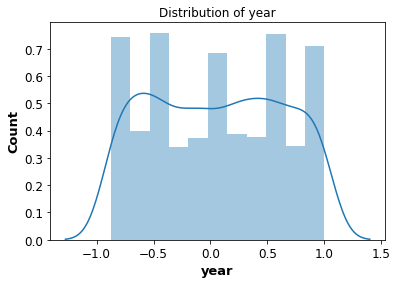

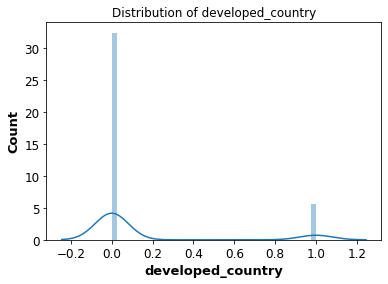

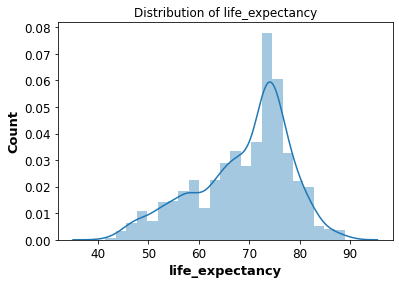

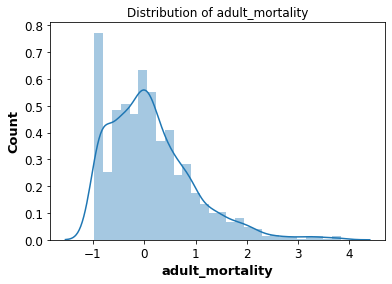

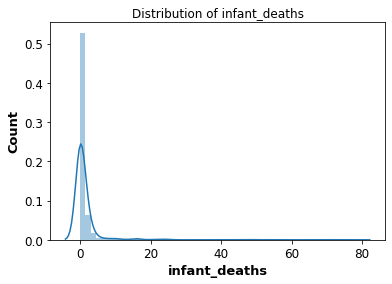

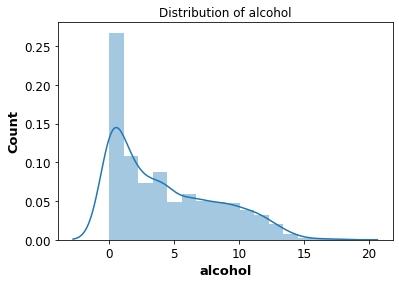

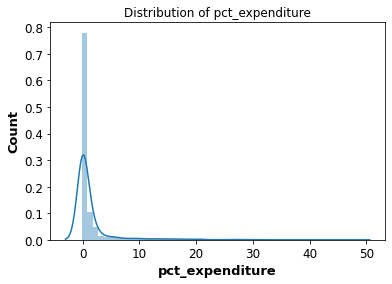

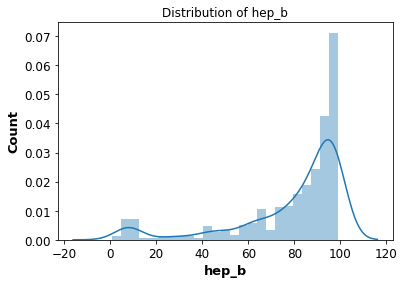

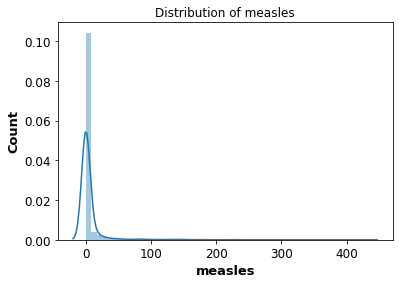

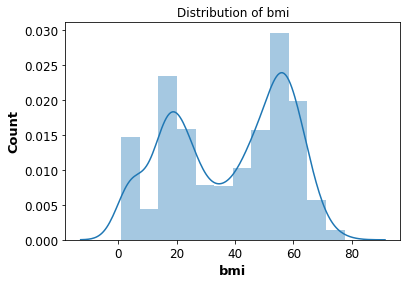

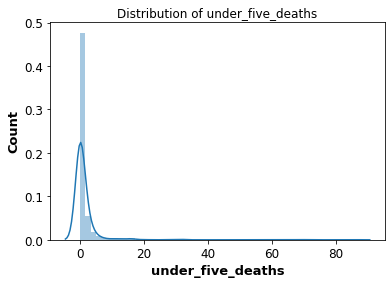

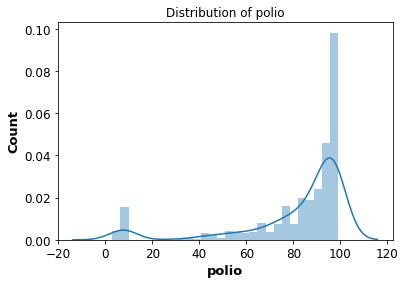

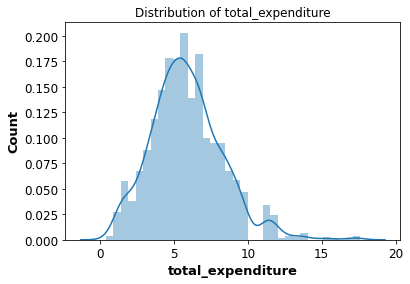

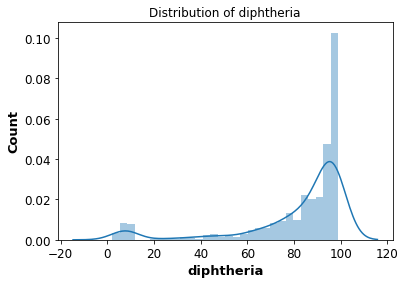

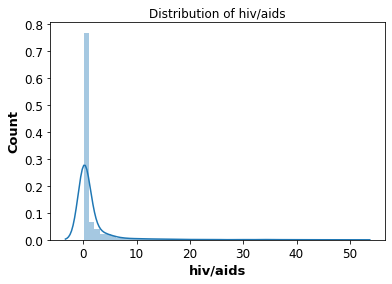

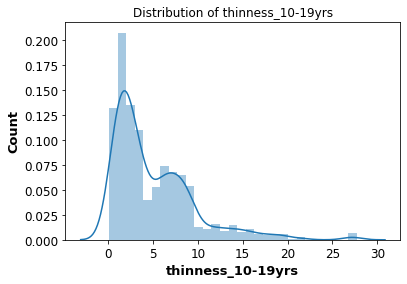

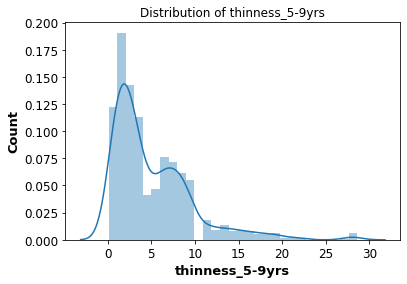

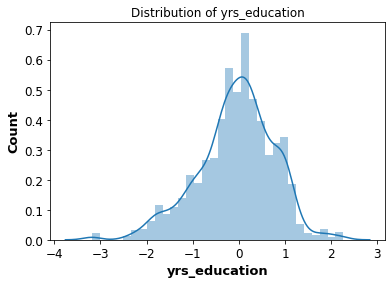

In [17]:
explore.distplot(train_scaled, train_scaled.columns)

In [18]:
train_scaled.dtypes

country               object
year                 float64
developed_country      int64
life_expectancy      float64
adult_mortality      float64
infant_deaths        float64
alcohol              float64
pct_expenditure      float64
hep_b                float64
measles              float64
bmi                  float64
under_five_deaths    float64
polio                float64
total_expenditure    float64
diphtheria           float64
hiv/aids             float64
thinness_10-19yrs    float64
thinness_5-9yrs      float64
yrs_education        float64
dtype: object

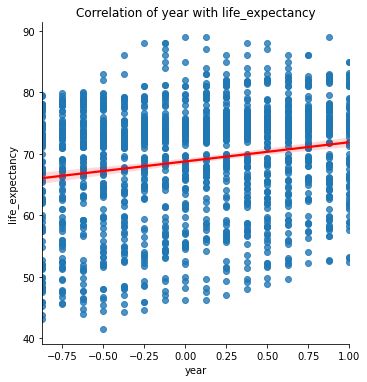

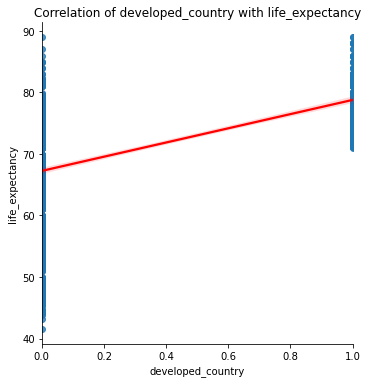

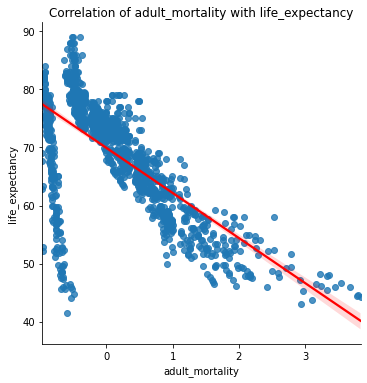

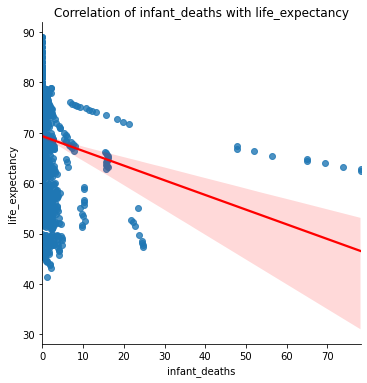

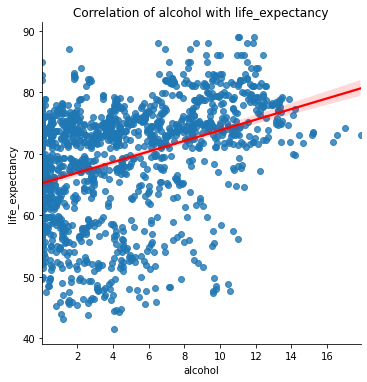

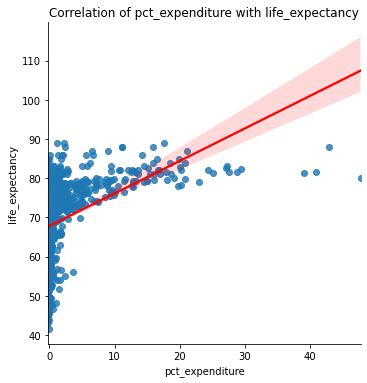

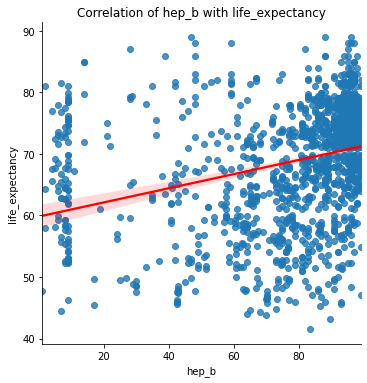

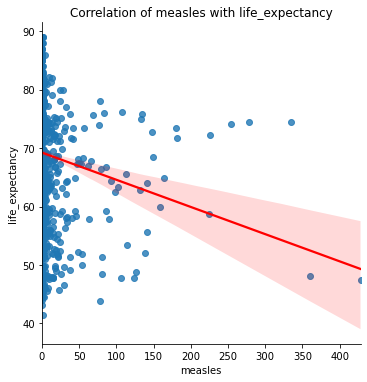

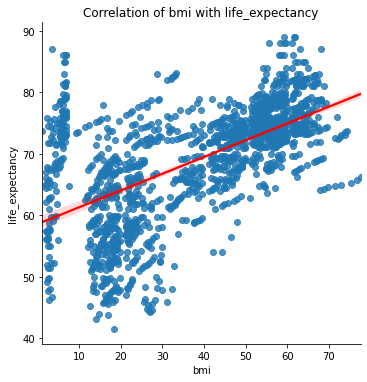

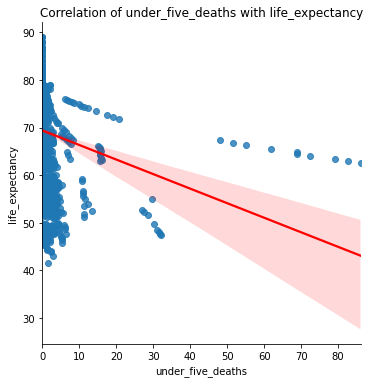

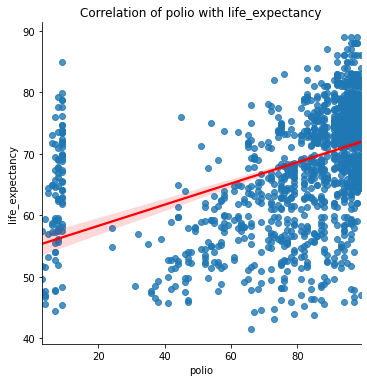

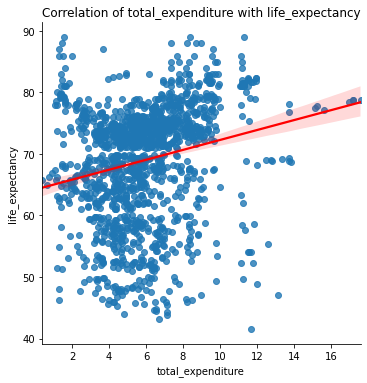

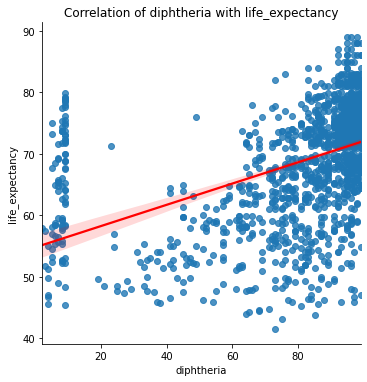

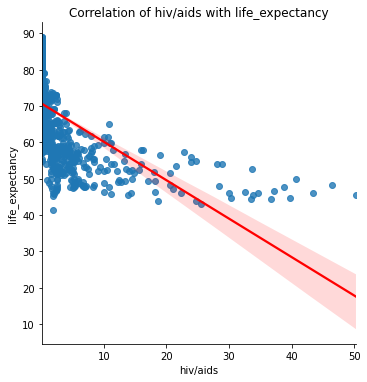

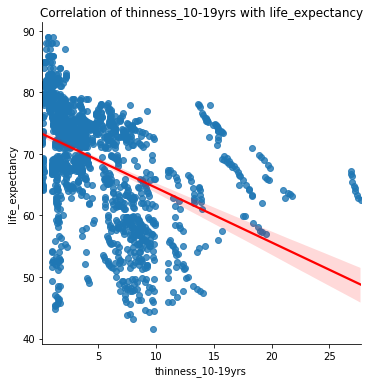

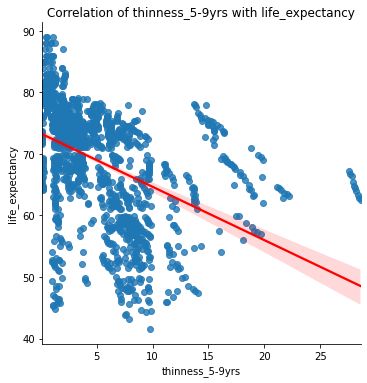

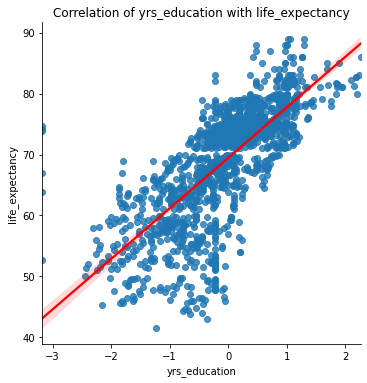

In [19]:
X = train_scaled.drop(columns=['life_expectancy', 'country'])
y = 'life_expectancy'
explore.lmplot(X, y, train_scaled)

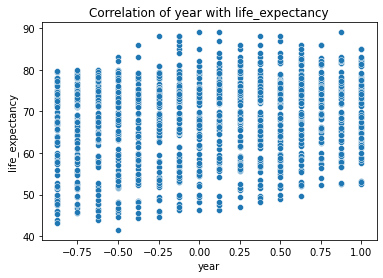

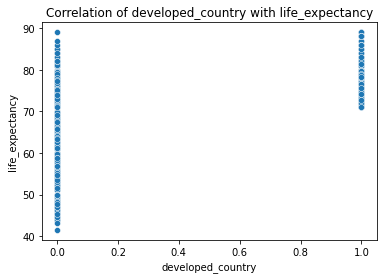

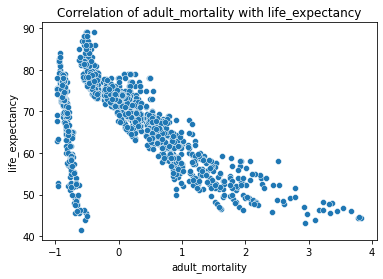

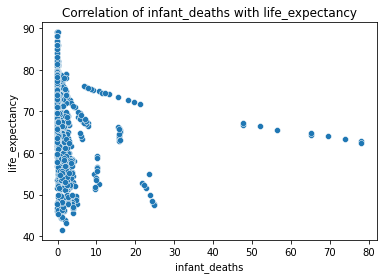

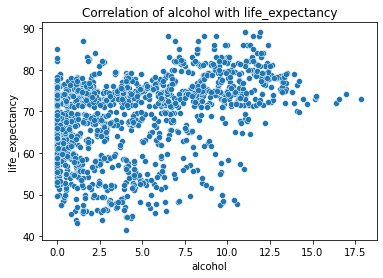

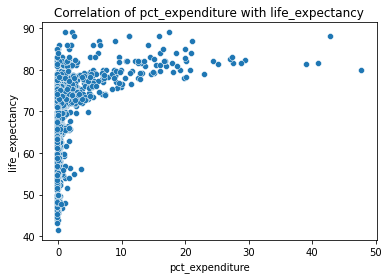

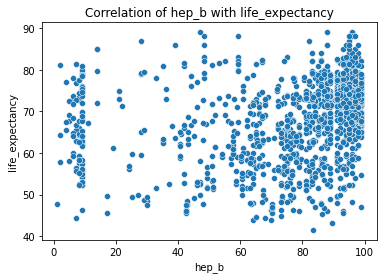

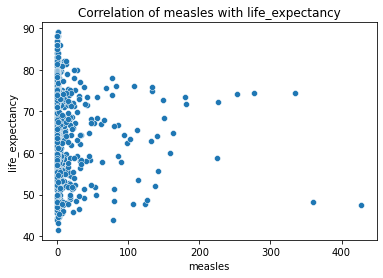

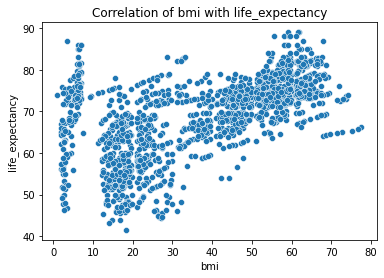

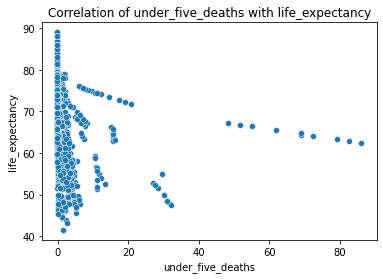

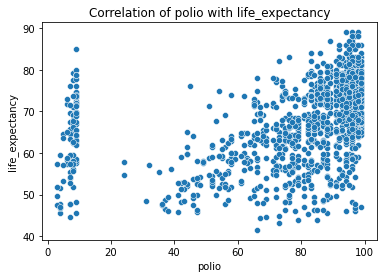

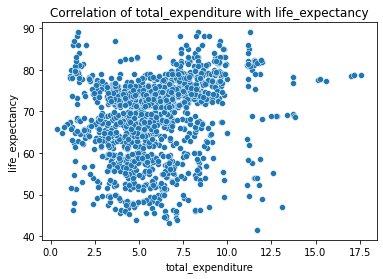

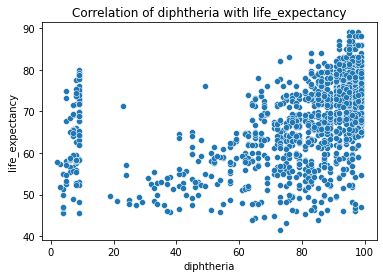

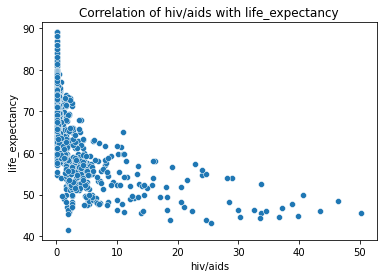

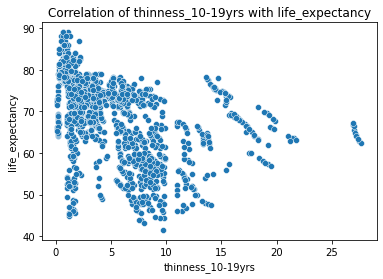

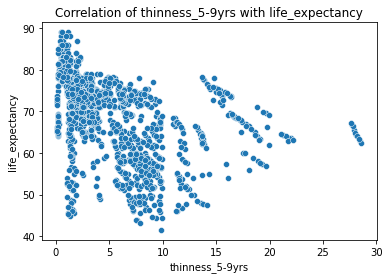

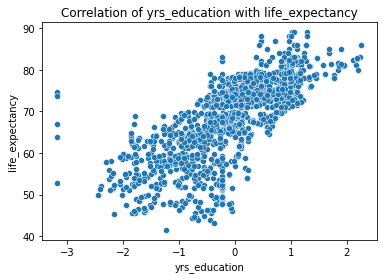

In [20]:
X = train_scaled.drop(columns=['life_expectancy', 'country'])
y= 'life_expectancy'

explore.scatterplot(X, y, train_scaled)

**Takeaway**
\
There is really good potential for some clusters here. There aren't any major correlations save for a few features. Clustering would help a lot here. Hopefully there is more time after initial completion to create some clusters.

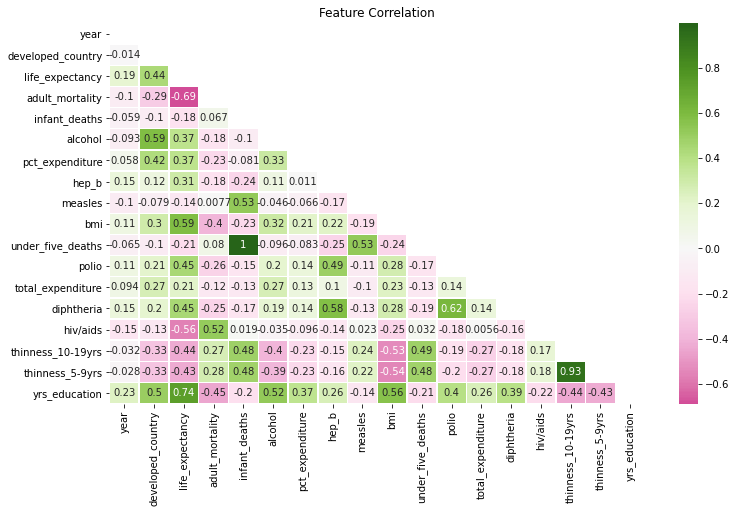

In [21]:
# take a look at a corner heatmap to assess correlation of independent and dependent variables
numerical = train_scaled
corr = numerical.corr()


plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap="PiYG", mask=mask)
plt.title('Feature Correlation')
plt.show()

**Takeaway**
\
I see a signification correlation of infant deaths and deaths under 5 years as well as thinness of variable ages to each other. These are repetitive features so it may be pointless to include both in the final model.

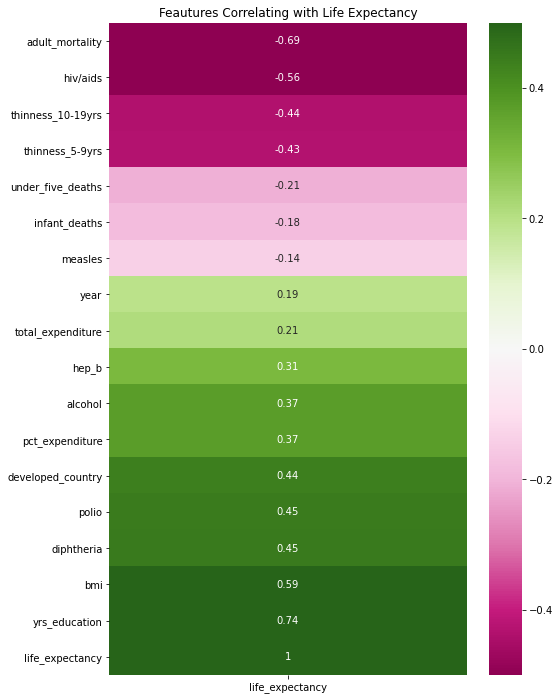

In [22]:
# Take a look at a heatmap of correlation to y target
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['life_expectancy']].sort_values(by='life_expectancy', ascending=True), cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Life Expectancy')
plt.show()

**Takeaway**
\
It's no surprise the year doesn't appear to have much correlation to life expectancy since the range is from 2000 to 2015.
\
**Statistics Test: Comparing two independent samples**
\
I will confirm using a two sample two tailed ttest. My assumption is that I can accept the null hypothesis and confirm no correlation.

${H_0}$ = The mean average of the first half of years == The mean average of the second half of years
\
${H_a}$ = The mean average of the first half of years != The mean average of the second half of years

In [23]:
# take a look at 
train_scaled.groupby('year').year.max()

year
-0.875   -0.875
-0.750   -0.750
-0.625   -0.625
-0.500   -0.500
-0.375   -0.375
-0.250   -0.250
-0.125   -0.125
 0.000    0.000
 0.125    0.125
 0.250    0.250
 0.375    0.375
 0.500    0.500
 0.625    0.625
 0.750    0.750
 0.875    0.875
 1.000    1.000
Name: year, dtype: float64

In [24]:
train_scaled[train_scaled.year<=0].year

2598   -0.625
1521   -0.875
2164   -0.625
1115   -0.125
989    -0.375
        ...  
2376   -0.875
2340   -0.375
1647   -0.625
123    -0.375
399    -0.875
Name: year, Length: 763, dtype: float64

In [25]:
# set up our confidence interval
conf_int = .95
alpha = 1 - conf_int

# assign my samples for a two sample two tailed ttest
sample1 = train_scaled[train_scaled.year<=0].year
sample2 = train_scaled[train_scaled.year>0].year

# assess the variance between the two samples
sample1.var(), sample2.var()

(0.07970672602277944, 0.08005417381890872)

In [26]:
# utitilize our ttest, set variance to true
t, p = stats.ttest_ind(sample1, sample2, equal_var=True)


if (p < alpha) & (t > 0):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


Just as I suspected, year does not appear to have an association to life expectancy

In [27]:
# assess top features using recursive feature elimination, compare to my suspected top features
top_features = explore.rfe(train_scaled.drop(columns=['country', 'life_expectancy']), train_scaled.life_expectancy, 9).to_list()
top_features

['developed_country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'pct_expenditure',
 'bmi',
 'under_five_deaths',
 'hiv/aids',
 'yrs_education']

### Explore Takeaways:
- We were able to get some good visuals using scatterplots.
- Clustering is a great possibility that could help us a lot in creating features
- The corner heatmap helped us see associations of independent variables and how some can be repetitive/duplicates
- Statistics supported my thought that year had no association to our target variable
- Using recursive feature elimination supported my suspisions of which features best predict y target.

## Modeling

In [28]:
# split X and y dataframes using my split_ytarget function
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_ytarget(train, validate, test, 'life_expectancy')

In [29]:
# assign my top features from exploration
X_train = train[top_features]
X_validate = validate[top_features]
X_test = test[top_features]

# since both infant_deaths and under_five_deaths made it into top features and they are similar,
# we will drop one
X_train.drop(columns='infant_deaths', inplace=True)
X_validate.drop(columns='infant_deaths', inplace=True)
X_test.drop(columns='infant_deaths', inplace=True)

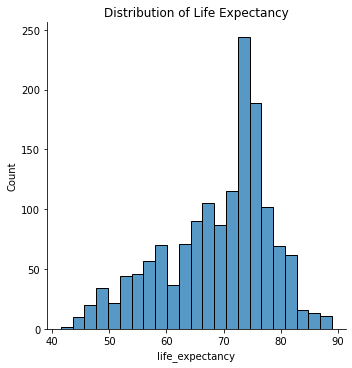

In [30]:
# set up our baseline model

# first visualize distribution of y target
sns.displot(y_train)
plt.title('Distribution of Life Expectancy');

### Baseline Model (Mean Average)

In [31]:
# utilize mean to create baseline model

# change y dataframes from arrays to dfs
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. Predict log error_baseline mean
baseline_mean = y_train['life_expectancy'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean


# 3. RMSE of log error mean
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.baseline_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.life_expectancy, y_validate.baseline_mean)**(1/2)

print("RMSE using Mean Average\nTrain/In-Sample: ", round(rmse_train, 3), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 3))

RMSE using Mean Average
Train/In-Sample:  9.268 
Validate/Out-of-Sample:  9.34


### Model 1 (LinearRegression)

In [33]:
# create the model object
lm = LinearRegression(normalize=True)

rmse_train, rmse_validate = explore.rmse(lm, X_train, X_validate, y_train, y_validate, 'life_expectancy', 'model1')

RMSE for model1 using LinearRegression(normalize=True) 
Training/In-Sample:  4.243287769187369 
Validation/Out-of-Sample:  4.53623009201453



### Model 2 (TweedieRegressor)

In [44]:
glm = TweedieRegressor(power=0, alpha=1.0)

rmse_train, rmse_validate = explore.rmse(glm, X_train, X_validate, y_train, y_validate, 'life_expectancy', 'model2')

RMSE for model2 using TweedieRegressor(power=0) 
Training/In-Sample:  4.9758390215252915 
Validation/Out-of-Sample:  5.291497577288724



### Model 3 (LassoLars)

In [45]:
lars = LassoLars(alpha=1.0)

rmse_train, rmse_validate = explore.rmse(lars, X_train, X_validate, y_train, y_validate, 'life_expectancy', 'model3')

RMSE for model3 using LassoLars() 
Training/In-Sample:  9.267766349581116 
Validation/Out-of-Sample:  9.340476678053715



### Model 4 (PolynomialRegression)

In [46]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

lm2 = LinearRegression(normalize=True)

# fit and transform X_train_scaled
X_train2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate2 = pf.transform(X_validate)

rmse_train, rmse_validate = explore.rmse(lm2, X_train2, X_validate2, y_train, y_validate, 'life_expectancy', 'model4')

RMSE for model4 using LinearRegression(normalize=True) 
Training/In-Sample:  3.2171175547913196 
Validation/Out-of-Sample:  3.508582492630084



### Modeling Takeaways:
- H

## Conclusion:

\
**With more time:**
- I would continue to impute the remainder of my nulls as opposed to just dropping them.
- I would utilize clustering to create few features and see I can create more correlated features
- I would assess the outliers and utilize different scaling methods to see if that has an impact on model performance.